In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import os
from img_preprocessing import mask_circle
import settings

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def display(func):
    def display_func(*args, **kwargs):
        img = func(*args, **kwargs)
        cvt_img = img
        plt.figure(figsize=(8, 8))
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap='gray')
        return img
    return display_func

In [9]:
@display
def load_img(*args, **kwargs):
    return cv2.imread(*args, **kwargs)

def run_pipeline(pipeline):
    curr_result = pipeline[0][0](*pipeline[0][1], **pipeline[0][2])
    for func, args, kwargs in pipeline[1:]:
        curr_result = func(curr_result, *args, **kwargs)

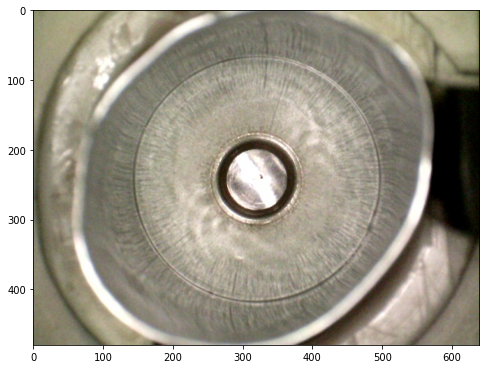

In [4]:
img = load_img('../img/Limpias/A150 - 20200630_085434.jpg')

In [5]:
@display
def find_main_circle(img):
    cvt_img = img
    if len(cvt_img.shape) == 3:
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #cvt_img[cvt_img < 70] = 0
    circles = cv2.HoughCircles(cvt_img, cv2.HOUGH_GRADIENT, 1, 10, 100, 100, minRadius=40)
    radius_list = circles[0, :, 2]
    min_radius = np.min(radius_list)
    main_radius = min_radius
    #main_radius = np.min(radius_list[radius_list > 1.5 * min_radius])
    print(min_radius)
    print(len(circles))
    main_circle = circles[0, np.where(radius_list == main_radius)[0][0], :]
    img = img.copy()
    x, y, rad = main_circle
    cv2.circle(img, (x, y), rad, color=(255, 255, 255), thickness=5)
    cv2.circle(img, (x, y), int(4.2 * rad), color=(255, 255, 255), thickness=5)
    return img

@display
def find_edges(img, *args, **kwargs):
    cvt_img = img
    if len(cvt_img.shape) == 3:
        cvt_img = cv2.cvtColor(cvt_img, cv2.COLOR_BGR2GRAY)
    return cv2.Canny(cvt_img, *args, **kwargs)

@display
def gamma_filter(img, gamma):
    return (255 * (img / 255) ** (1 / gamma)).astype(np.uint8)

@display
def equalizeHist(img):
    if len(img.shape) == 3:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hsv[:, :, 2] = cv2.equalizeHist(hsv[:, :, 2])
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return cv2.equalizeHist(img)

@display
def threshold(*args, **kwargs):
    ret, tresh = cv2.threshold(*args, **kwargs)
    return tresh

@display
def adaptThresh(*args, **kwargs):
    return cv2.adaptiveThreshold(*args, **kwargs)

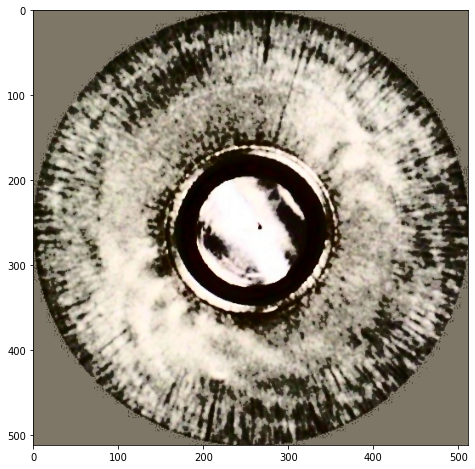

In [39]:
img = load_img('../img/train/clean/A150 - 20200630_085434.jpg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
channels = cv2.split(img)
channels[0] = cv2.equalizeHist(channels[0])
img = cv2.merge(channels)
img = cv2.cvtColor(img, cv2.COLOR_YUV2RGB)

plt.imshow(img)

TypeError: only size-1 arrays can be converted to Python scalars

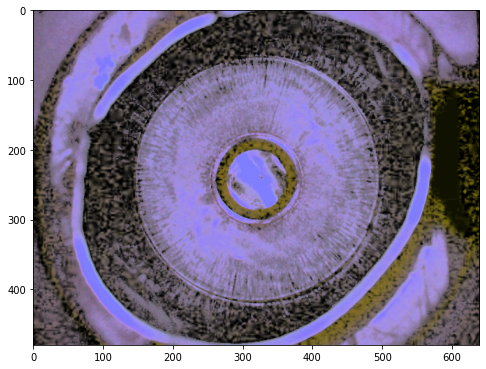

In [37]:
pipeline = [
    (cv2.cvtColor, (img, cv2.COLOR_BGR2YUV), {}),
    (equalizeHist, (), {}),
    (cv2.cvtColor, (img, cv2.COLOR_YUV2BGR), {}),
    #(gamma_filter, (img, 0.7), {}),
    #(cv2.GaussianBlur, ((11, 11), ), {"sigmaX": 2, "sigmaY": 2}),
    #(threshold, (20, 255, cv2.THRESH_BINARY_INV), {}),
    #(display(cv2.morphologyEx), (cv2.MORPH_GRADIENT, np.ones((3,3), np.uint8)), {}),
    #(cv2.ad, ((5, 5), ), {"sigmaX": 2, "sigmaY": 2}),
    #(adaptThresh, (255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 7, 5), {}),
    #(display(cv2.morphologyEx), (cv2.MORPH_CLOSE, np.ones((3,3), np.uint8)), {}),
    #(display(cv2.morphologyEx), (cv2.MORPH_OPEN, np.ones((5,5), np.uint8)), {}),
    #(gamma_filter, (2, ), {}),
    #(equalizeHist, (), {}),
    #(find_edges, (120, 255), {'L2gradient': True}),
    #(find_main_circle, (), {})
]
#for channel in range(3):
#    hist = cv2.calcHist([img], [channel], None, [256], [0, 256])
#    plt.plot(hist)
#    plt.show()
run_pipeline(pipeline)

## Model testing

In [66]:
model = tf.keras.models.load_model('../models/model_filtered_3/model_total.h5')

In [67]:
def decode_label(label):
    if "clean" in label:
        return 0
    else:
        return 1

def decode_image(image_data):  
    image = tf.image.decode_jpeg(image_data, channels=3)        
    image = tf.image.resize(image, [480, 480])
    image = tf.cast(image, tf.float32) / 255.0
    return image
    
def read_image(file_path):
    return tf.io.read_file(file_path)

def parse_input(file_name_input, label_input):
    image = read_image(file_name_input)
    image = decode_image(image)
    return image, label_input

def load_dataset(file_names):
    labels = [decode_label(value) for value in file_names]
    dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))
    dataset = dataset.map(parse_input)
    return dataset

def get_dataset(file_names):
    dataset = load_dataset(file_names)
    dataset = dataset.batch(16)
    return dataset

val_paths = []
test_paths = []

for dirname, _, filenames in os.walk('../img/test'):
    for filename in filenames:
        test_paths.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('../img/dev'):
    for filename in filenames:
        val_paths.append(os.path.join(dirname, filename))

In [6]:
dev_dataset = get_dataset(val_paths)
test_dataset= get_dataset(test_paths)

y_dev_pred = (model.predict(dev_dataset)> 0.5).astype(int)
y_dev_real = np.array([decode_label(path) for path in val_paths])
y_test_pred = (model.predict(test_dataset)> 0.5).astype(int)
y_test_real = np.array([decode_label(path) for path in test_paths])

In [7]:
print(classification_report(y_dev_pred, y_dev_real))
print(classification_report(y_test_pred, y_test_real))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       511
           1       0.78      1.00      0.88        14

    accuracy                           0.99       525
   macro avg       0.89      1.00      0.94       525
weighted avg       0.99      0.99      0.99       525

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       511
           1       0.79      1.00      0.88        15

    accuracy                           0.99       526
   macro avg       0.89      1.00      0.94       526
weighted avg       0.99      0.99      0.99       526



In [16]:
for path in os.listdir('../img/test_special/clean'):
    path = f"../img/test_special/clean/{path}"
    cv2.imwrite(path, mask_circle(cv2.resize(cv2.imread(path), dsize=(settings.IMG_DIMENSION_W, settings.IMG_DIMENSION_H))))

In [17]:
img_dataset = get_dataset([f"../img/test_special/clean/{filename}" for filename in os.listdir('../img/test_special/clean')])

In [21]:
(model.predict(img_dataset) > 0.99).astype(int)

array([[0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0]])

Found 10 images belonging to 2 classes.


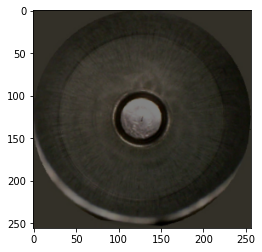

In [34]:
gen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=(0.3, 1.5),
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,
)
plt.imshow(next(gen.flow_from_directory(f"../img/test_special"))[0][1])

In [17]:
from joblib import load
import gc
import seaborn as sns

model_dir = "../models/AutoencoderOptuna/"
model = tf.keras.models.load_model(f"{model_dir}/model_total_autoencoder.h5")
history = load(f"{model_dir}/history.joblib")
# history_lr = load(f"{model_dir}/history_lr.joblib")

Found 1113 images belonging to 1 classes.


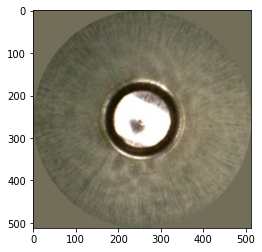

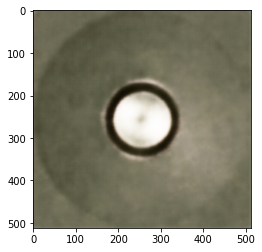

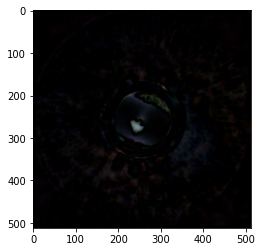

In [30]:
gen = ImageDataGenerator(
    rescale=1./255,
)
img_generator = gen.flow_from_directory(
    f"../img/test/",
    target_size=(512, 512),
    batch_size=16,
    class_mode="input",
    classes=['clean']
)
img, _ = next(img_generator)
index = np.random.randint(0, 16)
y_real = (img[index] * 255).astype(np.uint8)
y_pred = (model.predict(img)[index] * 255).astype(np.uint8)
diff = np.abs(y_pred.astype(np.float32) - y_real.astype(np.float32)).astype(np.uint8)
# diff = diff.astype(np.uint8)
plt.imshow(y_real)
plt.figure()
plt.imshow(y_pred)
plt.figure()
plt.imshow(cv2.erode(diff, kernel=np.ones((5, 5))))

<Figure size 432x288 with 0 Axes>

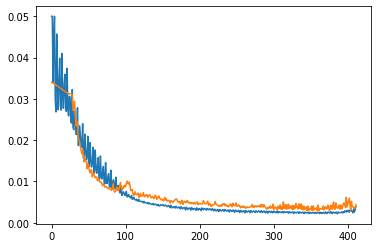

<Figure size 432x288 with 0 Axes>

In [16]:
plt.plot(np.clip(history['mse'], 0, 0.05))
plt.plot(np.clip(history['val_mse'], 0, 0.05))
plt.figure()
#plt.plot(history_lr['lr'])

In [44]:
img_generator = ImageDataGenerator(rescale=1/255.0)

dataset = img_generator.flow_from_directory(
    '../img/dev',
    batch_size=12,
    class_mode='binary',
    classes=['clean', 'dirty'],
    target_size=(512, 512)
)

Found 1130 images belonging to 2 classes.


In [45]:
mean_values = []
mse_values = []
count_values = []
labels = []
IMPORTANCE_TRIGGER = 40 / 255.0

for i in range(100):
    batch = next(dataset)
    y_real = batch[0]
    y_pred = model.predict(batch[0])
    diff = y_real - y_pred
    abs_diff = np.abs(diff)
    mse_values.extend(np.var(abs_diff, axis=(1, 2, 3)))
    mean_values.extend(np.mean(abs_diff, axis=(1, 2, 3)))
    count_values.extend((abs_diff > IMPORTANCE_TRIGGER).sum(axis=(1, 2, 3)))
    labels.extend(batch[1])
    if i % 10 == 0:
        print(i)
    gc.collect()

mse_values = np.array(mse_values)
labels = np.array(labels)

0
10
20
30
40
50
60
70
80
90


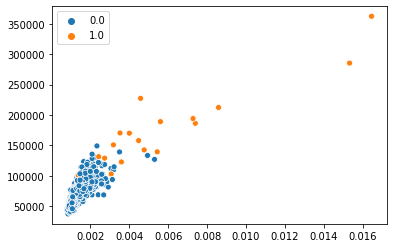

In [52]:
sns.scatterplot(mse_values, count_values, hue=labels)

In [50]:
from sklearn.metrics import f1_score

best_score = -9999
best_mse_trigger = None
for mse_trigger in np.arange(0.001, 0.014, 0.0001):
    score = f1_score(labels, (mse_values > mse_trigger).astype(int))
    if score > best_score:
        best_score = score
        best_mse_trigger = mse_trigger

In [51]:
best_score

0.742857142857143

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [117]:
X = np.transpose(np.array([mse_values, mean_values, count_values]))
y = np.array(labels)

In [126]:
reg = LogisticRegression()
scaler = StandardScaler()

X_train = scaler.fit_transform(X)
y_train = y
reg.fit(X_train, y_train)

LogisticRegression()

In [127]:
print(classification_report(reg.predict(X_train), y))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1181
         1.0       0.48      0.91      0.62        11

    accuracy                           0.99      1192
   macro avg       0.74      0.95      0.81      1192
weighted avg       0.99      0.99      0.99      1192



In [99]:
X_test = scaler.transform(np.transpose(np.array([mse_values, mean_values, count_values])))
y_test = np.array(labels)

print(classification_report(reg.predict(X_test), y_test))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      1089
         1.0       0.59      0.91      0.71        11

    accuracy                           0.99      1100
   macro avg       0.79      0.95      0.86      1100
weighted avg       0.99      0.99      0.99      1100



In [18]:
import joblib

In [22]:
study = joblib.load('../models/AutoencoderOptuna/study.joblib')

In [24]:
study.best_params

{'with_dropout': False,
 'learning_rate': 2.2982188293452283e-05,
 'loss_func': 'binary_crossentropy'}

In [33]:
for trial in study.get_trials():
    if trial.params['with_dropout']:
        print(trial.value, ": ", trial.params['learning_rate'])

0.028970135375857353 :  5.075616806528796e-05
0.031214676797389984 :  0.00016404852134333623
0.027605049312114716 :  0.0004205369208620264
0.03403539955615997 :  1.2762034841209113e-06
